In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Importing Dataset from Kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josealg","key":"7a48c6e737bf20559554911d371a75bc"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd #Print Working Directory

/content


In [ ]:
!kaggle datasets download -d muhammadmuzamil5500/gemstones

 97% 207M/213M [00:03<00:00, 83.9MB/s]
100% 213M/213M [00:03<00:00, 62.4MB/s]


In [ ]:
!unzip /content/gemstones.zip

Streaming output truncated to the last 5000 lines.
  inflating: FYP_Datasets/test/Ruby/Ruby_543.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_544.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_545.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_546.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_547.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_548.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_549.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_550.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_551.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_552.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_553.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_554.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_555.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_556.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_557.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_558.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_559.jpg  
  inflating: FYP_Datasets/test/Ruby/Ruby_560.jpg  
  inflating: FYP_Datasets/test/

Convert dataset into a PyTorch dataset

In [3]:
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader, random_split
import torchvision

# Define the desired image size
desired_image_size = (224, 224)

# Transformation for resizing and converting to tensor
transform = torchvision.transforms.Compose([
    Resize(desired_image_size),
    ToTensor(),
])

# Load datasets with resizing and transforming to tensor
train_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/train', transform=transform)
test_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/test', transform=transform)
valid_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/validation', transform=transform)
print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Number of validation samples: ", len(valid_ds))

Number of train samples:  3040
Number of test samples:  1500
Number of validation samples:  1500


In [4]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [12]:
EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

In [7]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [13]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import transforms
import os

# Define the path for the saved model
saved_model_path = '/content/drive/MyDrive/FYP_Datasets/final_model.pth'

# Check if a saved model exists
if os.path.exists(saved_model_path):
    # If a saved model exists, load the model parameters
    model.load_state_dict(torch.load(saved_model_path))
    print("Pre-trained model loaded.")
else:
    # If no saved model exists, train the model
    print("No pre-trained model found. Training the model...")

    print("Number of train samples: ", len(train_ds))
    print("Number of test samples: ", len(test_ds))
    print("Number of validation samples: ", len(valid_ds))
    print("Detected Classes are: ", train_ds.class_to_idx)

    # DataLoader for train, test, and validation with resized data
    train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


    # Train the model
    for epoch in range(EPOCHS):
        model.train()
        for step, (x, y) in enumerate(train_loader):
            # Change input array into list with each batch being one element
            x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
            # Remove unnecessary dimension
            for index, array in enumerate(x):
                x[index] = np.squeeze(array)
            # Apply feature extractor, stack back into 1 tensor and then convert to tensor
            x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
            # Send to GPU if available
            x, y = x.to(device), y.to(device)
            b_x = Variable(x)   # batch x (image)
            b_y = Variable(y)   # batch y (target)
            # Feed through model
            output, loss = model(b_x, None)
            # Calculate loss
            if loss is None:
                loss = loss_func(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if step % 50 == 0:
                # Get the next batch for validation purposes
                valid = next(iter(valid_loader))
                valid_x, valid_y = valid[0].to(device), valid[1].to(device)
                # Get output (+ respective class) and compare to target
                valid_output, valid_loss = model(valid_x, valid_y)
                valid_output = valid_output.argmax(1)
                # Calculate Metrics
                valid_accuracy = accuracy_score(valid_y.cpu(), valid_output.cpu())
                valid_precision = precision_score(valid_y.cpu(), valid_output.cpu(), average='weighted', zero_division=1)
                valid_recall = recall_score(valid_y.cpu(), valid_output.cpu(), average='weighted', zero_division=1)
                valid_f1 = f1_score(valid_y.cpu(), valid_output.cpu(), average='weighted', zero_division=1)

                print('Epoch: ', epoch, '| train loss: %.4f' % loss,
                      '| valid accuracy: %.2f' % valid_accuracy,
                      '| valid precision: %.2f' % valid_precision,
                      '| valid recall: %.2f' % valid_recall,
                      '| valid F1: %.2f' % valid_f1)
    print("Training complete. Saving the model...")
    # Save the trained model
    torch.save(model.state_dict(), saved_model_path)
    print("Model saved.")

No pre-trained model found. Training the model...
Number of train samples:  3040
Number of test samples:  1500
Number of validation samples:  1500
Detected Classes are:  {'Emerald': 0, 'Fake_Emerald': 1, 'Fake_Ruby': 2, 'Fake_Turquoise': 3, 'Ruby': 4, 'Turquoise': 5}
Epoch:  0 | train loss: 1.7802 | valid accuracy: 0.20 | valid precision: 0.57 | valid recall: 0.20 | valid F1: 0.10
Epoch:  0 | train loss: 1.7653 | valid accuracy: 0.10 | valid precision: 0.33 | valid recall: 0.10 | valid F1: 0.04
Epoch:  0 | train loss: 1.7789 | valid accuracy: 0.50 | valid precision: 0.83 | valid recall: 0.50 | valid F1: 0.42
Epoch:  0 | train loss: 1.7964 | valid accuracy: 0.10 | valid precision: 0.41 | valid recall: 0.10 | valid F1: 0.02
Epoch:  0 | train loss: 1.8079 | valid accuracy: 0.20 | valid precision: 0.74 | valid recall: 0.20 | valid F1: 0.07
Epoch:  0 | train loss: 1.7959 | valid accuracy: 0.20 | valid precision: 0.91 | valid recall: 0.20 | valid F1: 0.15
Epoch:  0 | train loss: 1.7872 | val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


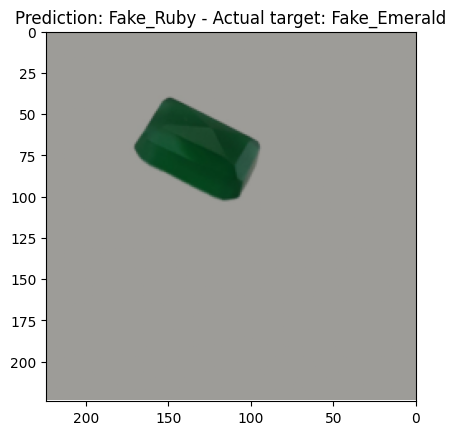

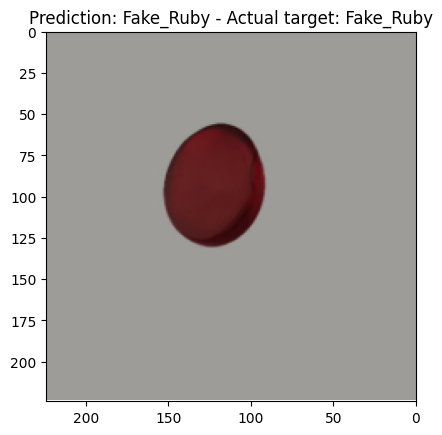

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


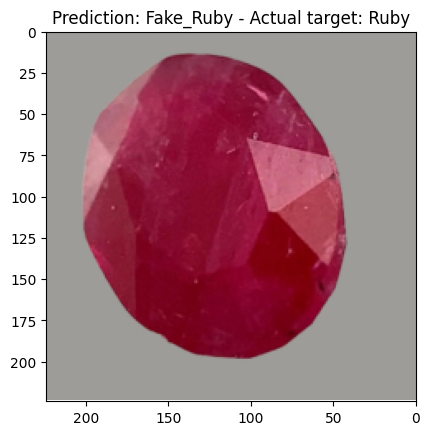

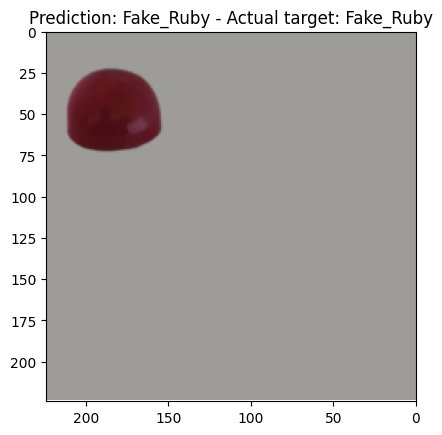

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


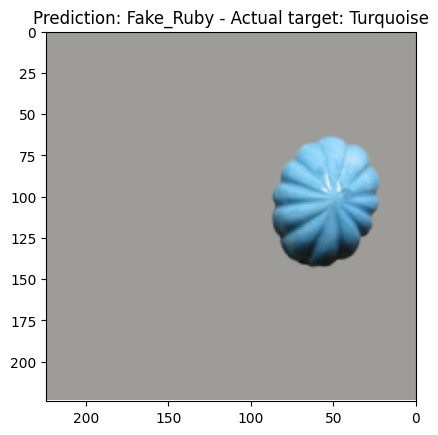

Average accuracy: 0.40 | Average precision: 0.40 | Average recall: 0.40 | Average F1: 0.40


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random

EVAL_BATCH = 1
eval_loader = data.DataLoader(test_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=2, pin_memory=True)

with torch.no_grad():
    model.eval()

    # Variables to store results
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, (inputs, target) in enumerate(eval_loader):
        # Reshape and get feature matrices as needed
        inputs = inputs[0].permute(1, 2, 0)
        original_input = inputs.clone()  # Save original input for visualization

        for index, array in enumerate(inputs):
            inputs[index] = np.squeeze(array)

        inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))
        inputs, target = inputs.to(device), target.to(device)

        # Generate prediction
        prediction, loss = model(inputs, None)  # Assuming you don't need the target for prediction
        probabilities = torch.nn.functional.softmax(prediction, dim=1)
        test_output = probabilities.argmax(1)

        # Calculate Metrics
        accuracy = accuracy_score(target.cpu(), test_output.cpu())
        precision = precision_score(target.cpu(), test_output.cpu(), average='weighted')
        recall = recall_score(target.cpu(), test_output.cpu(), average='weighted')
        f1 = f1_score(target.cpu(), test_output.cpu(), average='weighted')

        # Store results
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        # Predicted class value using argmax
        predicted_class = np.argmax(probabilities.cpu().numpy())
        value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
        value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target.item())]

        # Show result
        plt.imshow(original_input)
        plt.xlim(224, 0)
        plt.ylim(224, 0)
        plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
        plt.show()

        # Display results for 5 samples and break
        if i >= 4:
            break

    # Display average metrics for all samples
    avg_accuracy = np.mean(all_accuracies)
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)

    print('Average accuracy: %.2f' % avg_accuracy,
          '| Average precision: %.2f' % avg_precision,
          '| Average recall: %.2f' % avg_recall,
          '| Average F1: %.2f' % avg_f1)